In [1]:
import sys
sys.path.append('/nfs/homedirs/giri/masterthesis')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from robust_priornet.eval.uncertainty import UncertaintyMeasuresEnum

In [3]:
model_dir="runtime-model-vgg6"
batch_size=64
n_in=28
num_channels=1
data_dir="./runtime-data"
in_dataset="MNIST"
ood_dataset="OMNIGLOT"

## Eval task on train set (only 5000 images)

### OOD-detect task

In [5]:
out_dir=model_dir+"/ood-eval-train"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --train_dataset --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --train_dataset --model_dir runtime-model-vgg6 --result_dir runtime-model-vgg6/ood-eval-train ./runtime-data MNIST OMNIGLOT


In [6]:
os.system(cmd)

0

### Misclassify-detect task

In [7]:
out_dir=model_dir+"/eval-train"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task misclassification_detect --train_dataset --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task misclassification_detect --train_dataset --model_dir runtime-model-vgg6 --result_dir runtime-model-vgg6/eval-train ./runtime-data MNIST OMNIGLOT


In [8]:
os.system(cmd)

0

## Attack in-domain and eval ood-detect task on train set (same 5000 images)
### Same as previous task but the in-domain samples are transformed to adversarial samples and then evaluated for ood-detect task

#### Diff entropy attack

In [10]:
out_dir=model_dir+"/attack-fgsm-train-ood"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria diff_entropy --train_dataset --ood_eval --ood_dataset {ood_dataset} --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria diff_entropy --train_dataset --ood_eval --ood_dataset OMNIGLOT --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6 ./runtime-data MNIST runtime-model-vgg6/attack-fgsm-train-ood


In [8]:
os.system(cmd)

0

#### Attack's epsilon curve

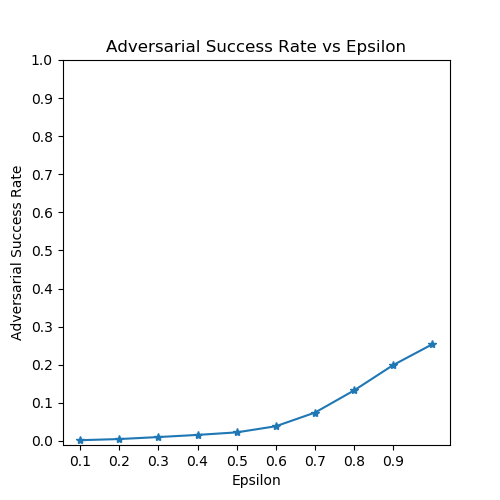

In [11]:
display(Image.open(os.path.join(out_dir, 'epsilon-curve.png')))

#### Confidence attack

In [14]:
out_dir=model_dir+"/attack-fgsm-train-ood-conf"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria confidence --train_dataset --ood_eval --ood_dataset {ood_dataset} --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria confidence --train_dataset --ood_eval --ood_dataset OMNIGLOT --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6 ./runtime-data MNIST runtime-model-vgg6/attack-fgsm-train-ood-conf


In [15]:
os.system(cmd)

0

#### Attack's epsilon curve

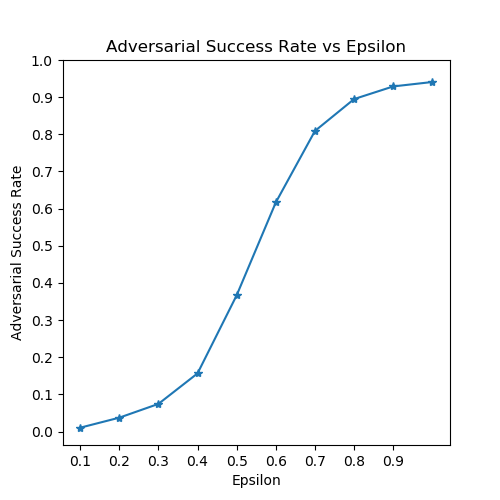

In [16]:
display(Image.open(os.path.join(out_dir, 'epsilon-curve.png')))

## Adversarial images (Diff entropy attack)

In [4]:
from robust_priornet.utils.visualizer import plot_adv_samples

In [5]:
def create_vis_plots(org_eval_dir, attack_dir, epsilon, plots_dir='vis', misclassified_indices=[]):
    # all images are saved in 'vis' directory under attack folder
    misclassified_samples = plot_adv_samples(org_eval_dir, attack_dir, epsilon, plots_dir, misclassified_indices)

    last_batch = misclassified_samples - (misclassified_samples%10)
    display(Image.open(f"{attack_dir}/e{epsilon}-attack/{plots_dir}/result_vis_{last_batch}.png")) # prints the last but one batch

# Misclassified samples under attack:  1018
# Correct classified samples prior attack:  4966
# Real adversarial samples under attack:  990


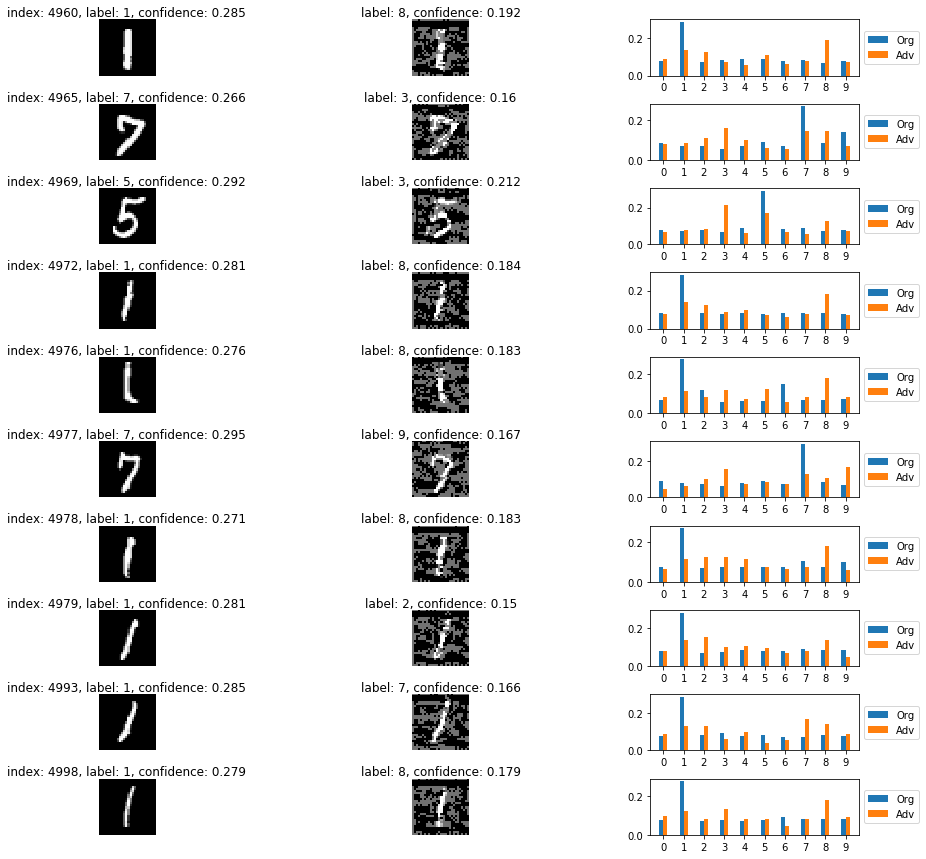

In [7]:
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood")
org_eval_dir=os.path.join(model_dir, "eval-train")
create_vis_plots(org_eval_dir, attack_dir, 0.9)

## Adversarial images (Confidence attack)

# Misclassified samples under attack:  790
# Correct classified samples prior attack:  4966
# Real adversarial samples under attack:  778


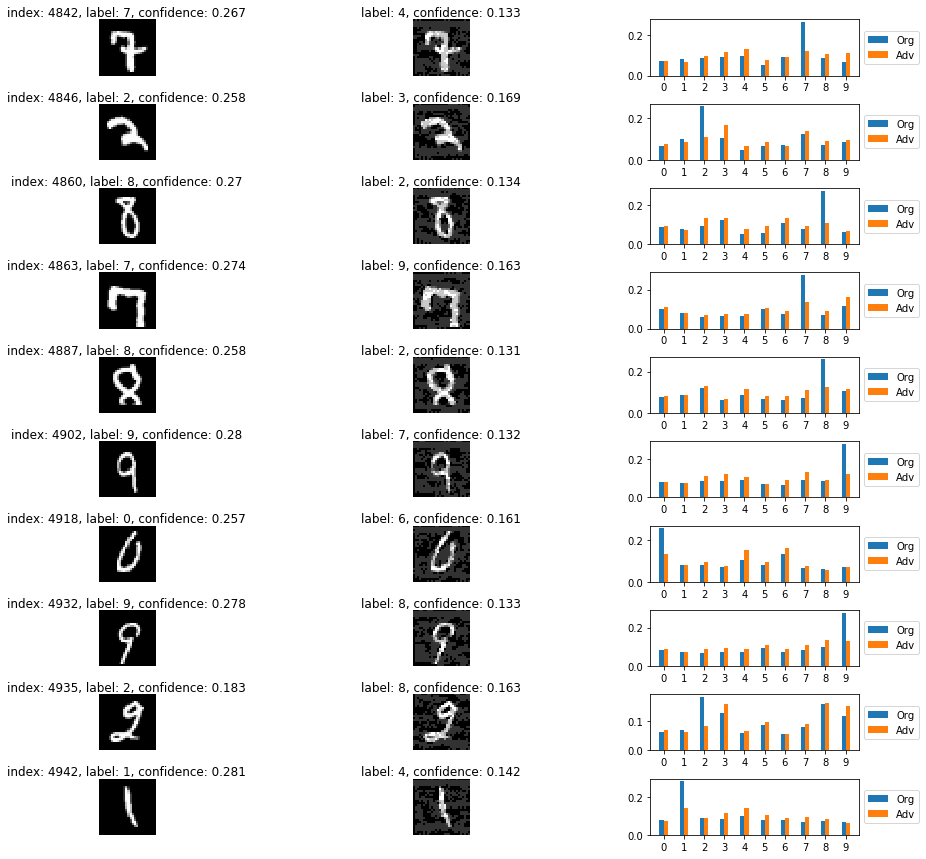

In [8]:
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-conf")
org_eval_dir=os.path.join(model_dir, "eval-train")
create_vis_plots(org_eval_dir, attack_dir, 0.4)

## PR and ROC curves under normal ood-eval (no-attack)

In [5]:
def display_pr_roc_curves(model_dir, eval_dir, uncertainty_measure: UncertaintyMeasuresEnum):
    #figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_PR_Curve.png'))
    display(img)
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_ROC_Curve.png'))
    display(img)

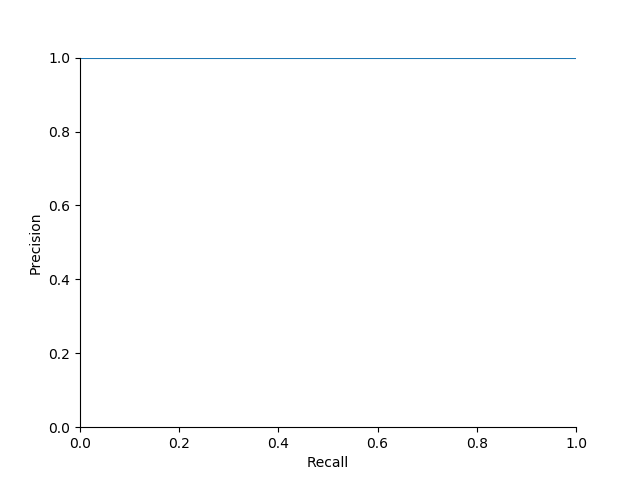

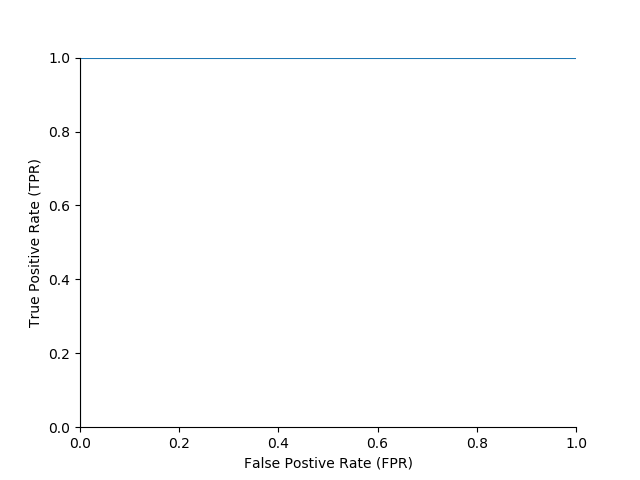

In [6]:
display_pr_roc_curves(model_dir, 'ood-eval-train', UncertaintyMeasuresEnum.CONFIDENCE)

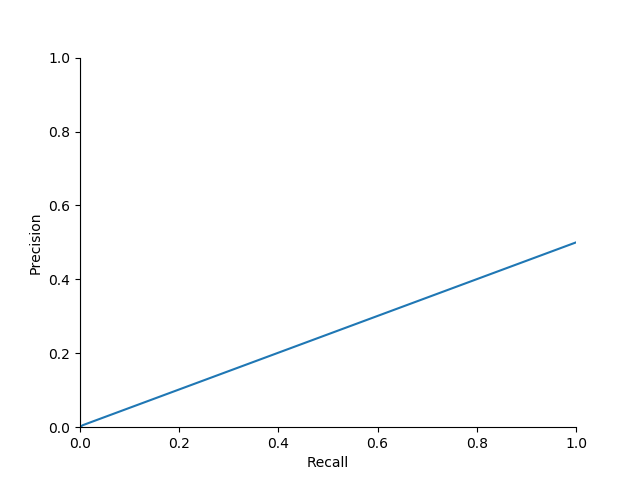

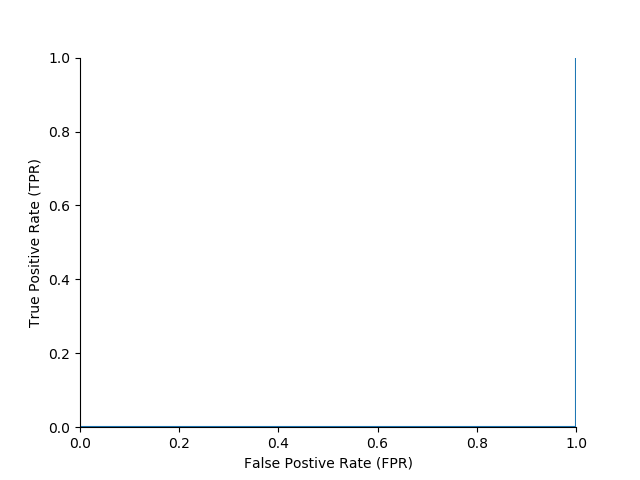

In [7]:
display_pr_roc_curves(model_dir, 'ood-eval-train', UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY)

## PR and ROC curves for ood-detect after adversarial image gen for ID data ( Diff Entropy attack)

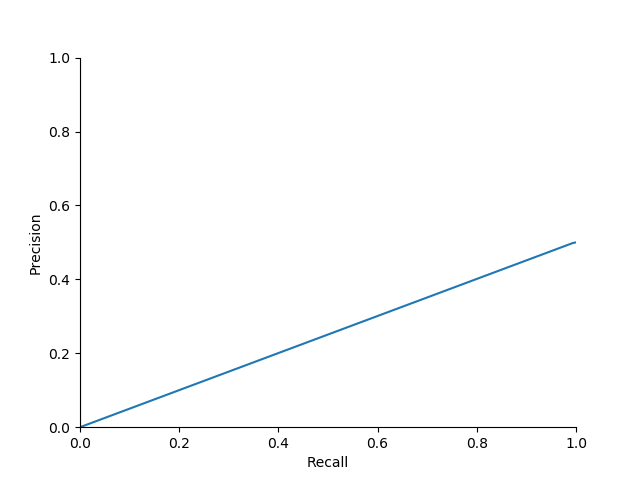

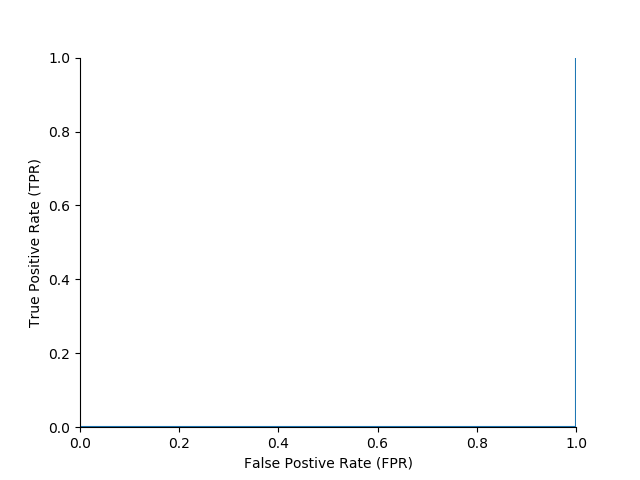

In [21]:
display_pr_roc_curves(model_dir, 'attack-fgsm-train-ood/e0.9-attack/ood_eval', UncertaintyMeasuresEnum.CONFIDENCE)

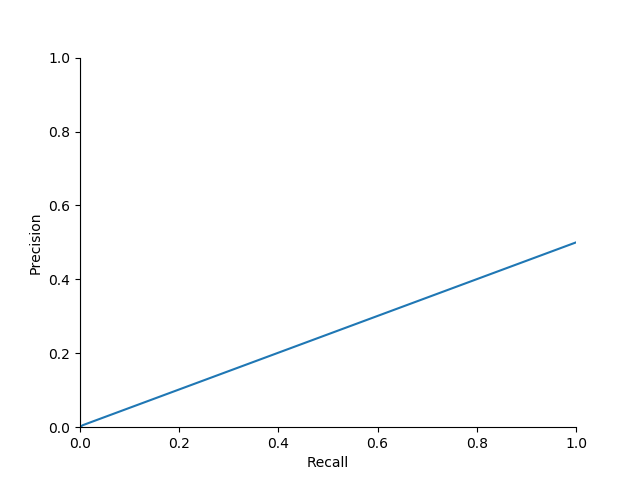

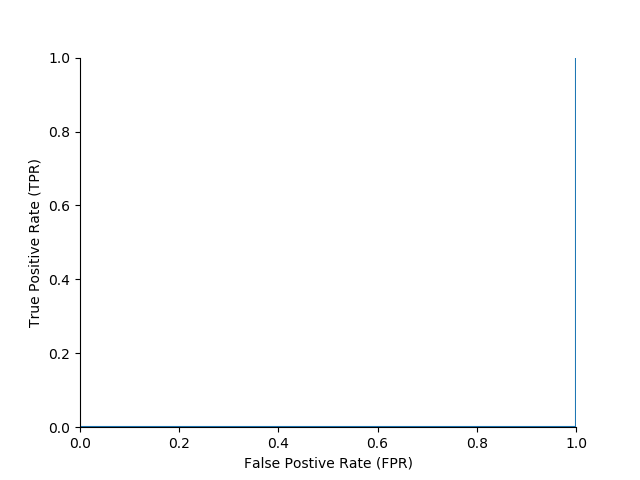

In [22]:
display_pr_roc_curves(model_dir, 'attack-fgsm-train-ood/e0.9-attack/ood_eval', UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY)

## PR and ROC curves for ood-detect after adversarial image gen for ID data ( Confidence attack)

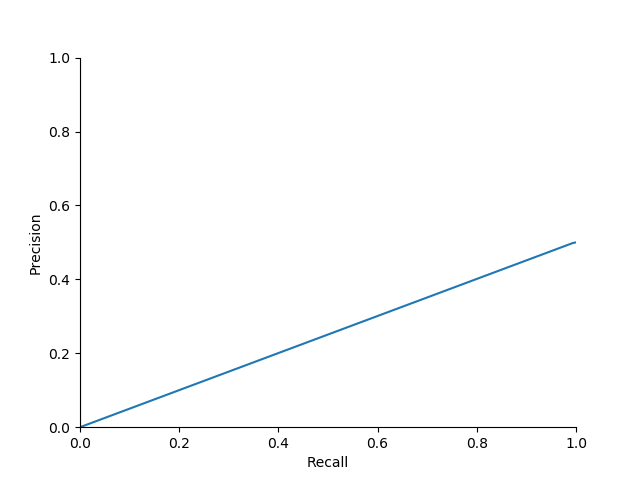

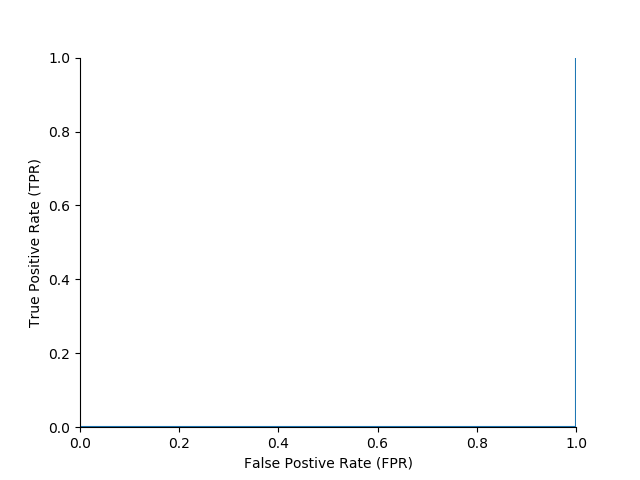

In [24]:
display_pr_roc_curves(model_dir, 'attack-fgsm-train-ood-conf/e0.9-attack/ood_eval', UncertaintyMeasuresEnum.CONFIDENCE)

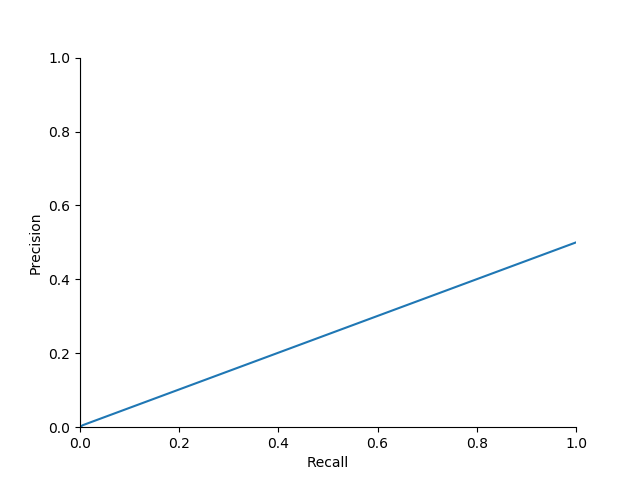

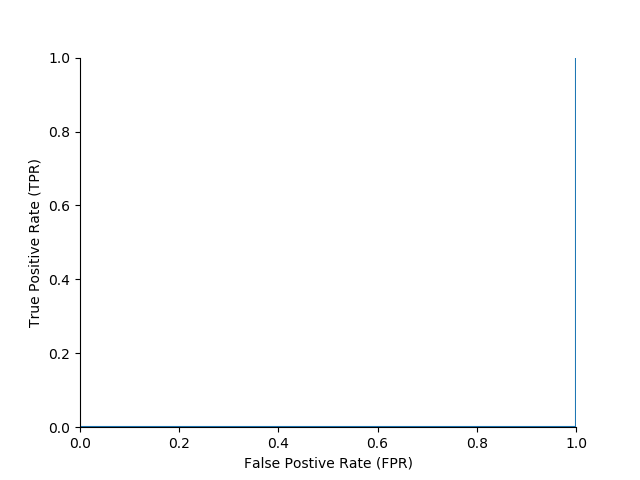

In [25]:
display_pr_roc_curves(model_dir, 'attack-fgsm-train-ood-conf/e0.9-attack/ood_eval', UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY)